In [4]:
import requests
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
import os
import xml.etree.ElementTree as ET
import json
import xmltodict
import xml.etree.ElementTree as ET
import pickle
import json
from typing import List

# ~~1. 특허 데이터 오픈 API 읽어오기~~
- 공공데이터포털, "한국과학기술연구원_특허DB"

In [ ]:
uri = "http://161.122.37.103:6736/openapi-data/service/thesis/"
encodingKey = ""
decodingKey = ""

service_name_dict = {'논문조회서비스': 'GetThesisInfoService', 
                     '특허조회서비스': 'GetPatentInfoService'}

In [ ]:

service_name_dict = {'논문조회서비스': 'GetThesisInfoService', 
                     '특허조회서비스': 'GetPatentInfoService'}

In [4]:
# response 반환
def getResponse(url, params):
    try:
        response = requests.get(url, params=params)
    except Exception as e:
        print(e)
        return
    return response

In [5]:
# 전체 데이터개수 반환
def getLastPageNum(response):
    soup =BeautifulSoup(response.text, 'xml')
    return int(soup.find("totalCount").text)

In [6]:
def createData(response):
    contents = response.json()
    return pd.DataFrame(contents['response']['body']['items'])

In [7]:
def getData(url, totalPageNum):
    df_list = []
    pageNum = 1
    params ={'serviceKey' : decodingKey, 'pageNo' : pageNum, 'numOfRows' : '1000', 'type' : 'json'}

    with tqdm(total=totalPageNum, desc=f"진행 상황") as pbar:
        for i in range(totalPageNum):
            df_list.append(createData(getResponse(url, params=params)))

            pageNum+=1
            params ={'serviceKey' : decodingKey, 'pageNo' : pageNum, 'numOfRows' : '1000', 'type' : 'json'}
            pbar.update(1)  # 진행 상황 업데이트
            
    return df_list

In [8]:
params ={'serviceKey' : encodingKey, 'pageNo' : 1, 'numOfRows' : '1000', 'type' : 'xml'}
target_uri = uri+service_name_dict['특허조회서비스']
target_uri = 'http://161.122.37.103:6736/openapi-data/service/patent/patentApplication?pageNo=1&applyDate=201411&serviceKey='+decodingKey
# 데이터 전체 개수 카운팅
totalDataLength = getLastPageNum(getResponse(target_uri, params))
totalPageNum = int(totalDataLength/1000)+1

df = pd.concat(getData(target_uri, totalPageNum), ignore_index=True)

AttributeError: 'NoneType' object has no attribute 'text'

# 2. USPTO 데이터

In [4]:
def read_pkl_file(filePath):
    with open(filePath, 'rb') as file:
        data = pickle.load(file)
    return data

In [5]:
patent_data_path = "./data/patent"
patent_file_list = os.listdir(patent_data_path)
len(patent_file_list)

1

In [6]:
for filename in tqdm(patent_file_list, desc=f"Read Patent File"):
    p_data: List[dict] = read_pkl_file(os.path.join(patent_data_path, filename))
    break

Read Patent File:   0%|          | 0/1 [00:09<?, ?it/s]


In [9]:
patent_df = pd.DataFrame()

for data in tqdm(p_data, desc=f"Read {filename} data"):  
    patent_name = data.get('bibliographic_information', {}).get('title_of_invention', None)
    code_information = data.get('classifications', {})
    cpc_ipc_code = code_information.get('main_or_locrano_class', None)
    edition = code_information.get('ipc_edition', None)
    patent_df = pd.concat([patent_df, pd.DataFrame([{'patent_title':patent_name, 'cpc_ipc_code': cpc_ipc_code, 'edition': edition}])])

Read 2003.pkl data: 100%|██████████| 187104/187104 [11:25<00:00, 272.81it/s]


In [11]:
len(patent_df), patent_df.tail()

(187104,
                                         patent_title  cpc_ipc_code edition
 0       Method and apparatus for pay-per-view system   [H04N  716]     [7]
 0  Method and apparatus for customized rendering ...   [H04N  900]     [7]
 0  Conditional access filter as for a packet vide...  [H04N  7167]     [7]
 0  System for distributing and handling electroni...   [H04N  545]     [7]
 0  Method and apparatus for lost connectivity rec...  [H04N  7173]     [7])

In [13]:
patent_df.to_csv("./data/output/2003_patent_titlt_code(241204,1).csv")

# 1. cpc코드

In [15]:
cpc_data_path = "./data/cpc_title"
cpc_file_list = [filename for filename in os.listdir(cpc_data_path) if filename.endswith("txt")]
len(cpc_file_list)

9

In [27]:
cpc_title_df = pd.DataFrame()
for filename in tqdm(cpc_file_list):
    df = pd.read_csv(os.path.join(cpc_data_path, filename), sep='\t', names=['code','depth','title'])
    cpc_title_df = pd.concat([cpc_title_df, df])
len(cpc_title_df), cpc_title_df.head()

100%|██████████| 9/9 [00:00<00:00, 49.79it/s]


(260820,
        code  depth                                              title
 0         D    NaN                                    TEXTILES; PAPER
 1       D01    NaN    NATURAL OR MAN-MADE THREADS OR FIBRES; SPINNING
 2      D01B    NaN  MECHANICAL TREATMENT OF NATURAL FIBROUS OR FIL...
 3  D01B1/00    0.0  Mechanical separation of fibres from plant mat...
 4  D01B1/02    1.0  Separating vegetable fibres from seeds, e.g. c...)

In [28]:
cpc_title_df.tail()

,code,depth,title
38974,H10N99/03,1.0,{Devices using Mott metal-insulator transition...
38975,H10N99/05,1.0,"{Devices based on quantum mechanical effects, ..."
38976,H99,NaN,SUBJECT MATTER NOT OTHERWISE PROVIDED FOR IN T...
38977,H99Z,NaN,SUBJECT MATTER NOT OTHERWISE PROVIDED FOR IN T...
38978,H99Z99/00,0.0,Subject matter not otherwise provided for in t...


In [30]:
cpc_title_df.to_csv("./data/output/cpc_title(2408).csv")

# 2. 키프리스 데이터

In [2]:
# MySQL에 연결

# 커서 생성
cursor = connection.cursor()

In [3]:
# 모든 데이터베이스 출력하는 쿼리 실행
cursor.execute("SHOW TABLES")

# 결과 출력
databases = cursor.fetchall()
for db in databases:
    print(db[0])

# # 커서 및 연결 종료
# cursor.close()
# connection.close()

MainClaim_patent
Main_patent
areabaselist
areacode
contenttypeid
patent
patent_claim
sigungu


In [3]:
# 쿼리 실행 (도로명주소관리번호에 대응하는 number 값 가져오기)
query = """
SELECT *
FROM Main_patent;
"""
mainPatent_df = pd.read_sql(query, con=connection)
len(mainPatent_df), mainPatent_df.head()

(2634934,
    seq applicationNumber                              inventionTitle  \
 0    1     1020190000013           인공지능 통합방재 배전반 및 인공지능 통합방재 배전반 시스템   
 1    2     1020190000030                                  주차장공유관리시스템   
 2    3     1020190000037       척추측만증 교정을 위한 방법 및 이러한 방법에 따라 제조된 교정기구   
 3    4     1020190000052  등속조인트용 케이지 및 그 케이지 및  슬리브 일체형 내륜을 갖는 등속조인트   
 4    5     1020190000075                        오버로크 재봉틀용 박음질 가이드 장치   
 
                                    inventionTitleEng applicationDate  \
 0  The AI unified anti-disaster panel and its system        20190101   
 1                         Parking Lot Sharing System        20190101   
 2  Correcting method for scoliosis and manufactur...        20190101   
 3  A cage for constant velocity joint and the  co...        20190102   
 4  DEVICE GUIDING STITCH FOR OVERLOCK SEWING  MAC...        20190102   
 
   registerNumber registerDate registerStatus originalApplicationKind  \
 0  1020076190000     20190730       

In [ ]:
# mainPatent_df.to_csv("./data/patent/kipris_main_patent.csv")

In [5]:
# 쿼리 실행 (도로명주소관리번호에 대응하는 number 값 가져오기)
query = """
SELECT *
FROM MainClaim_patent;
"""
mainClaim_df = pd.read_sql(query, con=connection)
len(mainClaim_df), mainClaim_df.head()

(2640867,
    seq applicationNumber                                              claim
 0    1     1020190000013  1. 하나 이상 배전반, 조기화재검지센서, 감시카메라로 구성된 배전반 통합 방재시스...
 1    2     1020190000030  1.        위 발명을 실시하기 위한 구체적인 내용 중 '2. 전산시스템 구성...
 2    3     1020190000037  1. 인체의 2차원 이미지를 획득하는 단계와,상기 2차원 이미지로부터 가상라인을 생...
 3    4     1020190000052  1. 외륜과 내륜 사이에 배치되도록 내경에는 곡선부를 성형하며, 볼의 이탈을 방지하...
 4    5     1020190000075  1. 오버로크 재봉틀의 일측에 설치된 브라켓과;상기 브라켓에 위치 변경 가능하게 장...)

In [ ]:
mainClaim_df.to_csv("./data/patent/kipris_claim_patent.csv")

: 

# 통계

In [ ]:
# 키프리스데이터 cpc 개수 통계
patent_cpc_count_dict = {}
error_data = []; not_upper_data = []

for _, data in tqdm(mainPatent_df.iterrows(), total = len(mainPatent_df)):
    cpc_str = data['listCPC']  # string
    cpc_str = cpc_str.replace("[", ""); cpc_str = cpc_str.replace("]", "")
    cpc_list = [cpc.strip() for cpc in cpc_str.split(",")]
    
    # 특허 하나에 들어있는 CPC 종류 체크
    cpc_check = []
    for cpc in cpc_list:
        try:
            target_cpc = cpc[0]
            if not target_cpc.isupper(): 
                target_cpc = target_cpc.upper()
                not_upper_data.append([data['seq'], cpc])
            
            if target_cpc not in cpc_check:
                cpc_check.append(target_cpc)
                
                # 전체 특허 CPC 카운팅
                if target_cpc not in patent_cpc_count_dict.keys(): patent_cpc_count_dict[target_cpc] = 1
                else: patent_cpc_count_dict[target_cpc]+=1
        except:
            error_data.append([data['seq'], cpc])
            continue
patent_cpc_count_dict

In [ ]:
df = pd.DataFrame([patent_cpc_count_dict]).T
df.to_csv("./data/output/data_CPC_count.csv", encoding='euc-kr')

In [ ]:
len(not_upper_data), not_upper_data[:5]

In [ ]:
len(error_data), error_data[:5]

# 연도별 통계

In [5]:
patent_path = "./data/patent/kipris_main_patent.csv"
patent_df = pd.read_csv(patent_path)

/tmp/ipykernel_457492/956689083.py:2: DtypeWarning: Columns (10,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  patent_df = pd.read_csv(patent_path)


In [6]:
patent_df.head(1)

,Unnamed: 0,seq,applicationNumber,inventionTitle,inventionTitleEng,applicationDate,registerNumber,registerDate,registerStatus,originalApplicationKind,...,applicantName,astrtCont,listRndMinistriesandoffices,listRndProject,listRndTask,listRndInstitution,listFamilycountryCode,listFamilycountryName,listFamilyKind,listFamilyNumber
0,0,1,1020190000013,인공지능 통합방재 배전반 및 인공지능 통합방재 배전반 시스템,The AI unified anti-disaster panel and its system,20190101,1020076190000,20190730,등록,신규,...,이승철,"저압반 내부의 통합제어계전기는 턴온 이벤트만 수신될 경우, 위험경보 이벤트를 발생...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
total_data_eda = []

for _, data in tqdm(patent_df.iterrows(), total=len(patent_df)):
    date = data['applicationDate']
    year = str(date)[:4]
    month = str(date)[4:6]

    date_dict = {'date':date, 'year': year, 'month': month}
    total_data_eda.append(date_dict)
    
len(total_data_eda)

100%|██████████| 2634934/2634934 [00:42<00:00, 62506.31it/s]


2634934

In [9]:
total_data_eda_df = pd.DataFrame(total_data_eda)
total_data_eda_df.head()

,date,year,month
0,20190101,2019,01
1,20190101,2019,01
2,20190101,2019,01
3,20190102,2019,01
4,20190102,2019,01


In [20]:
# 연도별 카운팅
yearly_counts = total_data_eda_df.groupby('year').size().reset_index(name='count')
total_count = yearly_counts['count'].sum()
yearly_counts['percentage'] = ((yearly_counts['count'] / total_count) * 100).round(2)
yearly_counts.to_csv("./data/output/kipris_yearly_data.csv", encoding='euc-kr')

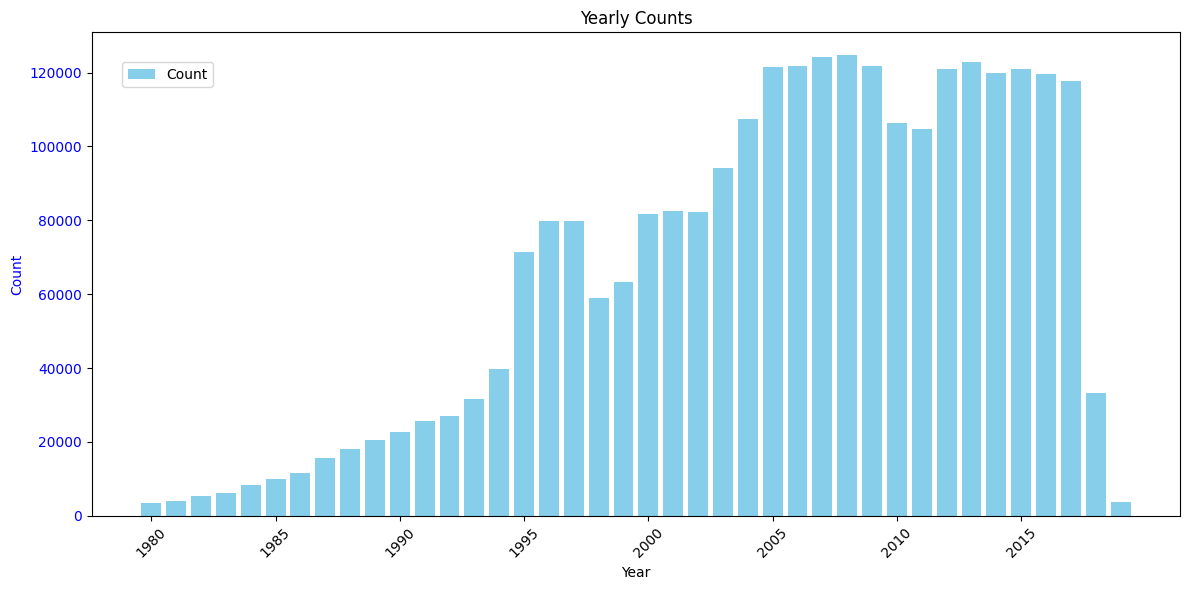

In [19]:
import matplotlib.pyplot as plt

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))  # 그래프 크기 확장

# 막대 그래프로 카운트 시각화
ax1.bar(yearly_counts['year'], yearly_counts['count'], color='skyblue', label='Count')
ax1.set_xlabel("Year")
ax1.set_ylabel("Count", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# X축 눈금 간격 조정 및 레이블 회전
step = 5  # 5년 단위로 눈금 표시
plt.xticks(yearly_counts['year'][::step], rotation=45)

# 그래프 타이틀 및 범례 설정
plt.title("Yearly Counts")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()